# SimpleCNN für MNIST (28×28)
Dieses Notebook definiert eine kleine Convolutional Neural Network (CNN) Architektur in PyTorch für Bilder der Größe 1×28×28 (z. B. MNIST). Anschließend führen wir einen kurzen Sanity-Check mit Zufallsdaten aus, um die Ausgabeform zu bestätigen.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 1×28×28 -> 32×28×28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # 32×28×28 -> 64×28×28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)  # halbiert H und W
        self.relu = nn.ReLU()           # ReLU als Member

        # Nach zwei Poolings: 28 -> 14 -> 7
        # Featuremap: 64×7×7 => 64*7*7 = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)   # 10 Klassen (Ziffern 0–9)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # -> 32×14×14
        x = self.pool(self.relu(self.conv2(x)))  # -> 64×7×7
        x = x.view(x.size(0), -1)               # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class SimpleCNNWithUnpooling(nn.Module):
    """
    Integrierte Pipeline: Encode -> Decode (Unpooling/Deconv) -> Klassifikation
    - Encoder: 2× (Conv + MaxPool2d(return_indices=True))
    - Decoder: 2× (MaxUnpool2d + ConvTranspose2d) rekonstruiert ein 1×28×28 Bild
    - Klassifikation: nutzt die rekonstruierte Ausgabe

    Forward gibt zurück: (reconstruction, logits, intermediate)
    """

    def __init__(self):
        super().__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # 1x28x28 -> 16x28x28
        self.enc_pool1 = nn.MaxPool2d(2, 2, return_indices=True)      # 16x28x28 -> 16x14x14

        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16x14x14 -> 32x14x14
        self.enc_pool2 = nn.MaxPool2d(2, 2, return_indices=True)      # 32x14x14 -> 32x7x7

        # Decoder
        self.dec_unpool2 = nn.MaxUnpool2d(2, 2)                       # 32x7x7 -> 32x14x14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)  # 32x14x14 -> 16x14x14

        self.dec_unpool1 = nn.MaxUnpool2d(2, 2)                       # 16x14x14 -> 16x28x28
        self.dec_deconv1 = nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1)   # 16x28x28 -> 1x28x28

        # Aktivierungen
        self.relu = nn.ReLU(inplace=True)
        self.out_act = nn.Sigmoid()  # für 0..1-Graustufenbilder

        # Klassifikationskopf: auf rekonstruierte Bilder (1x28x28)
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 1x28x28 -> 16x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # -> 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> 32x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # -> 32x7x7
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # Encode
        x1 = self.relu(self.enc_conv1(x))
        x1_pooled, idx1 = self.enc_pool1(x1)
        x2 = self.relu(self.enc_conv2(x1_pooled))
        x2_pooled, idx2 = self.enc_pool2(x2)

        # Decode
        x_up2 = self.dec_unpool2(x2_pooled, idx2, output_size=x2.shape)
        x_mid = self.relu(self.dec_deconv2(x_up2))
        x_up1 = self.dec_unpool1(x_mid, idx1, output_size=x1.shape)
        x_rec_logits = self.dec_deconv1(x_up1)
        x_rec = self.out_act(x_rec_logits)

        # Klassifikation
        logits = self.classifier(x_rec)
        return x_rec, logits, x_mid

class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 1x28x28 -> 32x28x28 -> 32x28x28 -> 32x14x14
        self.conv1a = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1a   = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, 3, padding=1)
        self.bn1b   = nn.BatchNorm2d(32)

        # Block 2: 32x14x14 -> 64x14x14 -> 64x14x14 -> 64x7x7
        self.conv2a = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2a   = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2b   = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        # statt großem FC: Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # 64x1x1

        self.fc = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)  # -> 32x14x14

        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)  # -> 64x7x7

        # Global Average Pooling
        x = self.gap(x)           # -> 64x1x1
        x = x.view(x.size(0), -1) # -> (B, 64)

        x = self.dropout(x)
        x = self.fc(x)            # -> (B, 10)
        return x


In [ ]:
# Trainiere erst SimpleCNN, dann SimpleCNNWithUnpooling und BetterCNN und vergleiche
from copy import deepcopy

# Daten
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True,
                          transform=transform)
val_ds   = datasets.MNIST(root="./data", train=False, download=True,
                          transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 20
lr = 1e-3

results = {}

# 1) SimpleCNN: reine Klassifikation
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion_cls = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion_cls(logits, y)
        loss.backward()
        optimizer.step()

    # Validierung Accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = correct/total*100
    print(f"[SimpleCNN] Epoch {epoch+1}: Val-Accuracy = {acc:.2f}%")

results["SimpleCNN"] = {"val_accuracy": acc}

# 2) SimpleCNNWithUnpooling: Rekonstruktion + Klassifikation
model_u = SimpleCNNWithUnpooling().to(device)
optimizer_u = torch.optim.Adam(model_u.parameters(), lr=lr)
criterion_rec = nn.MSELoss()

for epoch in range(n_epochs):
    model_u.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_u.zero_grad()
        x_recon, logits, _ = model_u(x)
        loss_rec = criterion_rec(x_recon, x)
        loss_cls = criterion_cls(logits, y)
        loss = loss_rec + loss_cls
        loss.backward()
        optimizer_u.step()

    # Validierung: MSE + Accuracy
    model_u.eval()
    total_loss_rec = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            x_recon, logits, _ = model_u(x)
            loss_rec = criterion_rec(x_recon, x)
            total_loss_rec += loss_rec.item() * x.size(0)


[SimpleCNN] Epoch 1: Val-Accuracy = 98.02%
[SimpleCNN] Epoch 2: Val-Accuracy = 99.01%
[SimpleCNN] Epoch 2: Val-Accuracy = 99.01%
[SimpleCNN] Epoch 3: Val-Accuracy = 98.36%
[SimpleCNN] Epoch 3: Val-Accuracy = 98.36%
[SimpleCNN] Epoch 4: Val-Accuracy = 99.20%
[SimpleCNN] Epoch 4: Val-Accuracy = 99.20%
[SimpleCNN] Epoch 5: Val-Accuracy = 99.01%
[SimpleCNN] Epoch 5: Val-Accuracy = 99.01%
[SimpleCNN] Epoch 6: Val-Accuracy = 99.13%
[SimpleCNN] Epoch 6: Val-Accuracy = 99.13%
[SimpleCNN] Epoch 7: Val-Accuracy = 99.02%
[SimpleCNN] Epoch 7: Val-Accuracy = 99.02%
[SimpleCNN] Epoch 8: Val-Accuracy = 98.93%
[SimpleCNN] Epoch 8: Val-Accuracy = 98.93%
[SimpleCNN] Epoch 9: Val-Accuracy = 99.07%
[SimpleCNN] Epoch 9: Val-Accuracy = 99.07%
[SimpleCNN] Epoch 10: Val-Accuracy = 99.05%
[SimpleCNN] Epoch 10: Val-Accuracy = 99.05%
[SimpleCNN] Epoch 11: Val-Accuracy = 99.27%
[SimpleCNN] Epoch 11: Val-Accuracy = 99.27%
[SimpleCNN] Epoch 12: Val-Accuracy = 99.15%
[SimpleCNN] Epoch 12: Val-Accuracy = 99.15%
[Simp

In [ ]:
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    mse = total_loss_rec/total
    acc_u = correct/total*100
    print(f"[SimpleCNNWithUnpooling] Epoch {epoch+1}: Val-MSE = {mse:.4f} | Val-Accuracy = {acc_u:.2f}%")

results["SimpleCNNWithUnpooling"] = {"val_accuracy": acc_u, "val_mse": mse}

# 3) BetterCNN: BatchNorm + GAP + Dropout
model_b = BetterCNN().to(device)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=lr)

for epoch in range(n_epochs):
    model_b.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_b.zero_grad()
        logits = model_b(x)
        loss = criterion_cls(logits, y)
        loss.backward()
        optimizer_b.step()

    # Validierung Accuracy
    model_b.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_b(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc_b = correct/total*100
    print(f"[BetterCNN] Epoch {epoch+1}: Val-Accuracy = {acc_b:.2f}%")

results["BetterCNN"] = {"val_accuracy": acc_b}

# Vergleichsausgabe
print("\n=== Vergleich ===")
print(f"SimpleCNN            -> Accuracy: {results['SimpleCNN']['val_accuracy']:.2f}%")
print(f"SimpleCNNWithUnpool  -> Accuracy: {results['SimpleCNNWithUnpooling']['val_accuracy']:.2f}% | MSE: {results['SimpleCNNWithUnpooling']['val_mse']:.4f}")
print(f"BetterCNN            -> Accuracy: {results['BetterCNN']['val_accuracy']:.2f}%")


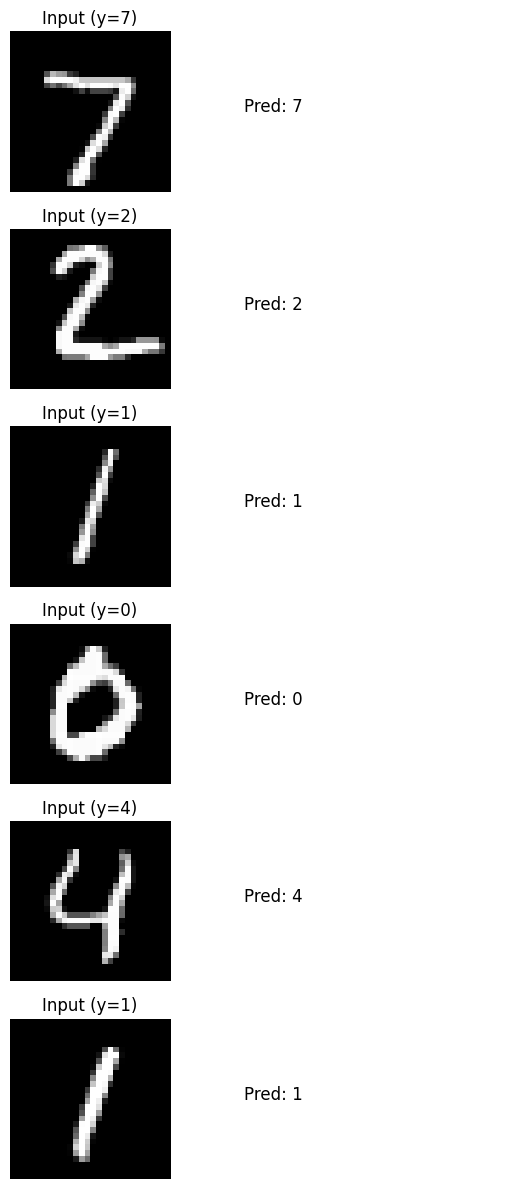

In [31]:
# Visualisierung: Eingabe, Zwischenbild (nach Unpooling/Deconv2) und Rekonstruktion + Prediction
import matplotlib.pyplot as plt
import numpy as np

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = next(iter(val_loader))
x_val, y_val = batch[0].to(device), batch[1]

with torch.no_grad():
    if MODEL_NAME == "SimpleCNNWithUnpooling":
        x_recon, logits, x_mid = model(x_val)
        preds = logits.argmax(dim=1).cpu().numpy()
        x_inp = x_val.cpu().numpy()
        x_mid_vis = x_mid.cpu().numpy()
        x_rec = x_recon.cpu().numpy()
        
        # Plot einige Beispiele
        n = 6
        fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(10, 2*n))
        for i in range(n):
            axes[i,0].imshow(x_inp[i,0], cmap='gray')
            axes[i,0].set_title(f'Input (y={y_val[i].item()})')
            axes[i,0].axis('off')
            
            # Zwischenbild hat 16 Kanäle: zeige Kanal 0
            axes[i,1].imshow(x_mid_vis[i,0], cmap='gray')
            axes[i,1].set_title('Intermediate (ch0)')
            axes[i,1].axis('off')
            
            axes[i,2].imshow(x_rec[i,0], cmap='gray')
            axes[i,2].set_title('Reconstruction')
            axes[i,2].axis('off')
            
            axes[i,3].text(0.1, 0.5, f'Pred: {preds[i]}', fontsize=12)
            axes[i,3].set_axis_off()
        plt.tight_layout()
        plt.show()
    else:
        logits = model(x_val)
        preds = logits.argmax(dim=1).cpu().numpy()
        x_inp = x_val.cpu().numpy()
        n = 6
        fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 2*n))
        for i in range(n):
            axes[i,0].imshow(x_inp[i,0], cmap='gray')
            axes[i,0].set_title(f'Input (y={y_val[i].item()})')
            axes[i,0].axis('off')
            axes[i,1].text(0.1, 0.5, f'Pred: {preds[i]}', fontsize=12)
            axes[i,1].set_axis_off()
        plt.tight_layout()
        plt.show()